In [1]:
%matplotlib notebook
%pylab
import pandas as pd
from time import time

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
from cg_dg_functions import *

In [3]:
%reload_ext autoreload
%autoreload 2

In [4]:
# Exact solution
def initial_condition(x, case):
    
    '''
    This function compute the initial condition
    
    Inputs:
    -------
            x: variable
            case: 1 for Gaussain, 2 for sinusoidal function
            
    Output:
    -------
           return the initial condition according to the case
    '''
    
    if (case == 1):
        return exp(-128*x**2)
    elif(case == 2):
        return sin(2*pi*x)

    
#time stuff
def time_step(dx, ax, bx, CFL, nel0, N, u, time_final, fixed_dt):
    
    if (fixed_dt == True):
        dx0 = (bx-ax)/(nel0*N)
        dtest = CFL*dx0/abs(u)
        ntime0 = int(time_final//dtest) + 1   # Number of time steps
        dt0 = time_final/ntime0

        f = log2(dx0/dx)
        dt = dt0/2**f
        ntime = int(ntime0*2**f)
        #print('ntime = {:d}'.format(ntime))
    else:        
        dtest = CFL*dx/abs(u)
        ntime = int(time_final/dtest) + 1    # Number of time steps
        dt = time_final/ntime
        #print('ntime = {:d}'.format(ntime))
        
    return dt, ntime

In [29]:
poly_order = array([1,2])         # polynomial order
#N_element = array([32,64])  # number of elements
N_element = array([32,64,128,256,512,1024])

kstages = 4               # RK2, RK3, RK4
dt = 1e-2                 # time-step, fraction of one revolution
CFL = 0.5                 # CFL number
time_final = 1.0          # final time in revolutions
integration_type = 2      # % = 1 is inexact and = 2 is exact
method_type = 'dg'        # CG or DG
iplot = False             # plot the solution
icase = 2                 # case number: 1 is a Gaussian and 2 is a sinusoidal
diss = 0 
u = 2
ax = -1
bx = 1
ntime = time_final/dt;

len_el = len(N_element)
len_pol = len(poly_order)
l2e_norm = zeros((len_pol, len_el))
Np_array = zeros((len_pol, len_el))

nel0 = N_element[0]

#Prep = []
#Integ = []

f = open("results_ext_dg.csv", "w+")
f.write("{:s},{:s},{:s},{:s},{:s},{:s},{:s},{:s},{:s},{:s},{:s}\n".format('order','element','walltime','Prep',\
                                    'Integ','time steps','dt','cfl','1-norm','2-norm','inf-norm'))
#f.write("{:>8s} {:>12s} {:>8s} {:>12s} {:>8s}".format('N','error(1)','rate(1)','error(2)','rate(2)'))

for iN in range(len_pol):
    N = poly_order[iN]
    if (integration_type == 1):
        Q = N
    elif (integration_type == 2):
        Q = N+1
    
    #time_listE = zeros((2, len_el))
    for e in range(len_el):
        nel = N_element[e]
        
        if (method_type == 'cg'):
            Np = nel*N + 1
        elif (method_type == 'dg'):
            Np = nel*(N+1)
        
        Np_array[iN,e] = Np
        
        #dx1 = (bx-ax)/(Np-1)
        #dt1, ntime1 = time_step(dx1, ax, bx, CFL, nel0, N, u, time_final, fixed_dt = False)
        # Call of 1D wave solver
        '''
        outputs:
        --------
        qexact         : Exact solution
        q              : Computed solution
        coord          : All grid points
        intma          : Intma(CG/DG)
        '''
        qexact, q, coord, intma, t_list, dt, ntime = cg_dgSolver(N, Q, nel, Np, ax, bx, integration_type,\
                                method_type,icase,diss,u, CFL, time_final, kstages, initial_condition)
        
        # compuation time 
        global_t = t_list[0] + t_list[1]
        #f.write("{},{},{},{},{},{},{},{},{}".format(global_t, t_list[0],\
        #t_list[1],ntime,dt,CFL,l1_norm,l2_norm,inf))
        #Prep.append(t_list[0])
        #Integ.append(t_list[1])
        
        # Compute L2- norm
        num = 0
        denom = 0
        error = zeros(Np)
        for i in range(Np):
            num = num + (q[i]-qexact[i])**2
            error[i] = abs(q[i]-qexact[i])
            denom = denom + (qexact[i])**2

        l1_norm = sum(error)
        inf_norm = max(error)
        l2e_norm[iN,e] = sqrt(num/denom)
        
        l2_norm = sqrt(num/denom)
        
        f.write("{:8d},{:d},{:.4e},{:.4e},{:.4e},{:d},{},{},{:.4e},{:.4e},{:.4e}\n".format(N, nel, global_t,\
                                    t_list[0], t_list[1],ntime,dt,CFL,l1_norm,l2_norm,inf_norm))
        #Compute a gridpoint solution
        x_sol = zeros(Np);
        for ie in range(1,nel+1):
            for i in range(N+1):
                ip = int(intma[i,ie-1])
                x_sol[ip] = coord[i,ie-1]
    
    if(iplot == True):
        figure(iN)
        plot(x_sol, qexact, label = 'Exact')
        plot(x_sol, q, '--', label = 'Computed')
        legend()
        
#time_list1 = array([Prep, Integ, array(Prep)+array(Integ)])

In [30]:
result = pd.read_csv("results_ext_dg.csv") 
result

,order,element,walltime,Prep,Integ,time steps,dt,cfl,1-norm,2-norm,inf-norm
0,1,32,0.027707,0.002110,0.025597,65,0.015385,0.5,1.999200,4.977700e-02,5.768200e-02
1,1,64,0.057366,0.019621,0.037745,129,0.007752,0.5,0.885620,1.088100e-02,1.141900e-02
2,1,128,0.069285,0.014300,0.054985,257,0.003891,0.5,0.419810,2.576000e-03,2.605100e-03
3,1,256,0.135860,0.025075,0.110780,513,0.001949,0.5,0.206710,6.341700e-04,6.358500e-04
4,1,512,0.312380,0.075302,0.237070,1025,0.000976,0.5,0.102950,1.579200e-04,1.580100e-04
5,1,1024,1.019100,0.420900,0.598180,2049,0.000488,0.5,0.051421,3.944000e-05,3.944600e-05
6,2,32,0.035403,0.004449,0.030954,129,0.007752,0.5,0.028371,4.927100e-04,5.897000e-04
7,2,64,0.078273,0.013733,0.064540,257,0.003891,0.5,0.007020,6.057800e-05,7.171000e-05
8,2,128,0.138420,0.022365,0.116050,513,0.001949,0.5,0.001748,7.533900e-06,8.873000e-06
9,2,256,0.275560,0.043656,0.231910,1025,0.000976,0.5,0.000437,9.401200e-07,1.103400e-06


In [ ]:
# Exact integration time
#header = pd.MultiIndex.from_product([poly_order, N_element], names = ['N','Elements'])
#time_exact = pd.DataFrame(time_list1, index = ['Prep','Integ','Global'], columns = header)

#time_exact

<IPython.core.display.Javascript object>


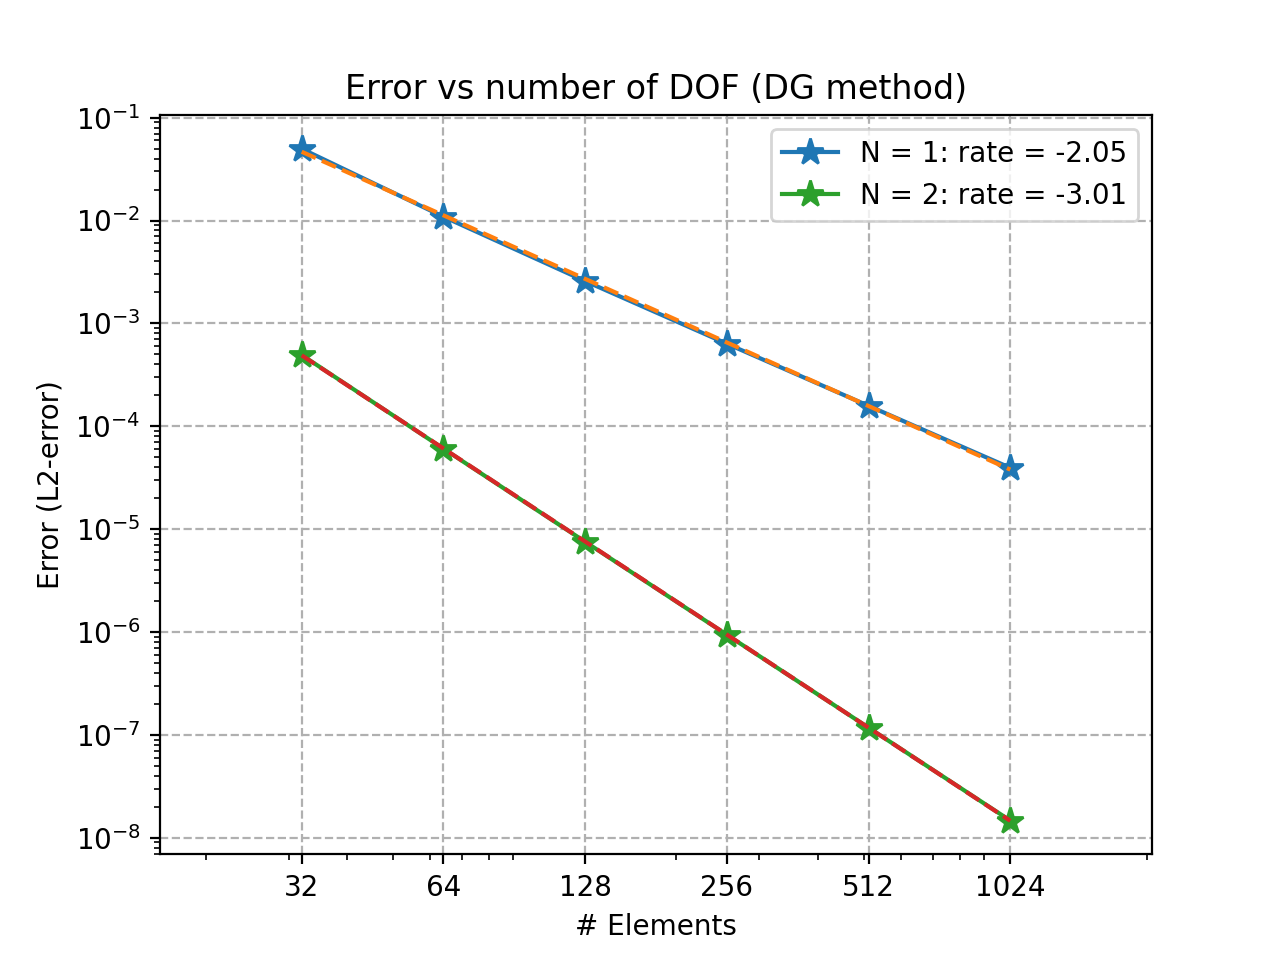

In [31]:
import cg_graphics
figure(5)
clf()
P = []   

for i in range(len(poly_order)):
    N = poly_order[i]
    #Nv = Np_array[i]
    Nv = N_element
    if(N == 6):
        p = polyfit(log(Nv[:3]), log(l2e_norm[i][:3]), 1)
    else:
        p = polyfit(log(Nv), log(l2e_norm[i]), 1)
        
    P.append(p[0])
    loglog(Nv, l2e_norm[i], '-*',markersize=10, label = 'N = {:d}: rate = {:.2f}'.format(N,p[0]))
    
    loglog(Nv, exp(polyval(p,log(Nv))), '--')
    
cg_graphics.set_xticks(N_element)
xlabel('# Elements')
ylabel('Error (L2-error)')
title('Error vs number of DOF ({:s} method)'.format(method_type.upper()))
#cg_graphics.set_xticks(N_element*N)  # Create nice tick marks for NE
grid(axis='both',linestyle='--')
legend()
show()   

In [33]:
poly_order = array([1,2])       # polynomial order
#N_element = array([32,64])  # number of elements
N_element = array([32,64,128,256,512,1024])
kstages = 4               # RK2, RK3, RK4
dt = 1e-2                 # time-step, fraction of one revolution
CFL = 0.5                 # CFL number
time_final = 1.0          # final time in revolutions
integration_type = 1      # % = 1 is inexact and = 2 is exact
method_type = 'dg'        # CG or DG
iplot = False             # plot the solution
icase = 2                 # case number: 1 is a Gaussian and 2 is a sinusoidal
diss = 0 
u = 2
ax = -1
bx = 1
ntime = time_final/dt;

len_el = len(N_element)
len_pol = len(poly_order)

l2I_norm = zeros((len_pol, len_el))
Np_array = zeros((len_pol, len_el))

nel0 = N_element[0]

Prep = []
Integ = []

f = open("results_in_cg.csv", "w+")
f.write("{:s},{:s},{:s},{:s},{:s},{:s},{:s},{:s},{:s},{:s},{:s}\n".format('order','element','walltime','Prep',\
                                    'Integ','time steps','dt','cfl','1-norm','2-norm','inf-norm'))

for iN in range(len_pol):
    N = poly_order[iN]
    if (integration_type == 1):
        Q = N
    elif (integration_type == 2):
        Q = N+1
    
    for e in range(len_el):
        nel = N_element[e]
        
        if (method_type == 'cg'):
            Np = nel*N + 1
        elif (method_type == 'dg'):
            Np = nel*(N+1)
        
        Np_array[iN,e] = Np
        
        #dx1 = (bx-ax)/(Np-1)
        #dt1, ntime1 = time_step(dx1, ax, bx, CFL, nel0, N, u, time_final, fixed_dt = False)
        # Call of 1D wave solver
        '''
        outputs:
        --------
        qexact         : Exact solution
        q              : Computed solution
        coord          : All grid points
        intma          : Intma(CG/DG)
        '''
        qexact, q, coord, intma, t_list, dt, ntime = cg_dgSolver(N, Q, nel, Np, ax, bx, integration_type,\
                                    method_type,icase,diss,u, CFL, time_final, kstages, initial_condition)
        
        # compuation time 
        
        global_t = t_list[0] + t_list[1]
        
        
        #Prep.append(t_list[0])
        #Integ.append(t_list[1])
        
        # Compute L2- norm
        num = 0
        denom = 0
        error = zeros(Np)
        for i in range(Np):
            num = num + (q[i]-qexact[i])**2
            error[i] = abs(q[i]-qexact[i])
            denom = denom + (qexact[i])**2

        l2I_norm[iN,e] = sqrt(num/denom)
        
        l1_norm = sum(error)
        inf_norm = max(error)
        #l2e_norm[iN,e] = sqrt(num/denom)
        
        l2_norm = sqrt(num/denom)
        
        f.write("{:8d},{:d},{:.4e},{:.4e},{:.4e},{:d},{},{},{:.4e},{:.4e},{:.4e}\n".format(N, nel, global_t,\
                                    t_list[0],t_list[1],ntime,dt,CFL,l1_norm,l2_norm,inf_norm))
        #Compute a gridpoint solution
        x_sol = zeros(Np);
        for ie in range(1,nel+1):
            for i in range(N+1):
                ip = int(intma[i,ie-1])
                x_sol[ip] = coord[i,ie-1]
    
    if(iplot == True):
        figure(iN)
        plot(x_sol, qexact, label = 'Exact')
        plot(x_sol, q, '--', label = 'Computed')
        legend()
        
#time_list = array([Prep, Integ, array(Prep)+array(Integ)])

In [34]:
result = pd.read_csv("results_in_dg.csv") 
result

,order,element,walltime,Prep,Integ,time steps,dt,cfl,1-norm,2-norm,inf-norm
0,1,8,0.004434,0.000767,0.003667,17,0.058824,0.5,10.450000,1.115400,1.306300
1,1,16,0.011798,0.001285,0.010513,33,0.030303,0.5,6.446000,0.314530,0.328750
2,1,32,0.017933,0.002102,0.015831,65,0.015385,0.5,3.286400,0.080303,0.080538
3,1,64,0.033591,0.003999,0.029592,129,0.007752,0.5,1.645100,0.020161,0.020146
4,1,128,0.065903,0.008964,0.056939,257,0.003891,0.5,0.822520,0.005045,0.005043
5,1,256,0.136990,0.021440,0.115550,513,0.001949,0.5,0.411240,0.001262,0.001261
6,2,8,0.007069,0.001109,0.005960,33,0.030303,0.5,4.553300,0.295640,0.300000
7,2,16,0.013546,0.001285,0.012261,65,0.015385,0.5,0.349250,0.013499,0.019971
8,2,32,0.027805,0.002258,0.025547,129,0.007752,0.5,0.069166,0.001270,0.001916
9,2,64,0.062390,0.004827,0.057563,257,0.003891,0.5,0.015256,0.000140,0.000201


In [ ]:
# Inexact integration time
#header = pd.MultiIndex.from_product([poly_order, N_element], names = ['N','Elements'])
#time_inexact = pd.DataFrame(time_list, index = ['Prep','Integ','Global'], columns = header)

#time_inexact

<IPython.core.display.Javascript object>


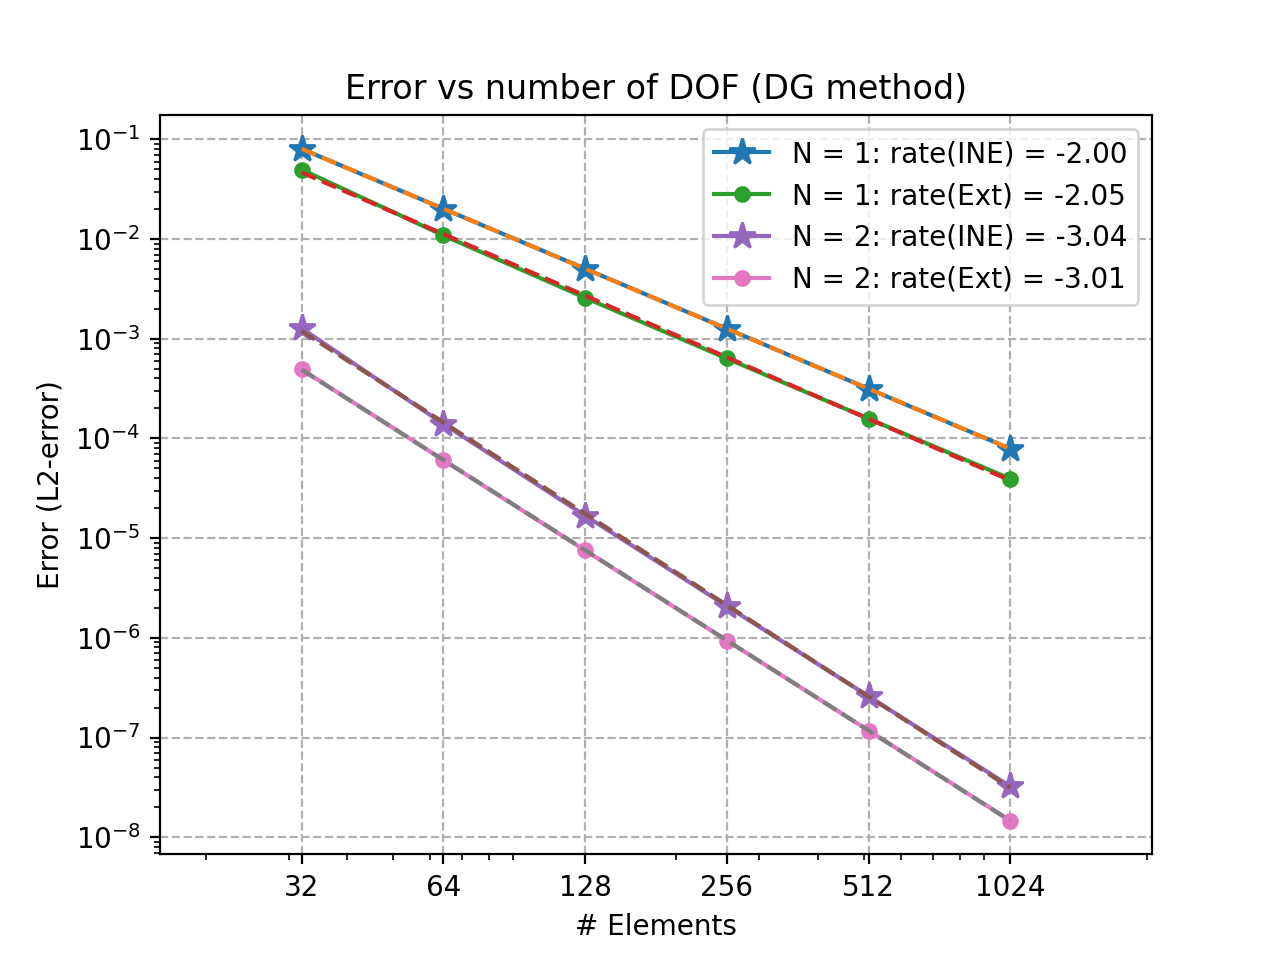

In [36]:
import cg_graphics
figure(6)
clf()
P = []   

for i in range(len(poly_order)):
    N = poly_order[i]
    #Nv = Np_array[i]
    Nv = N_element
    if(N == 6):
        p = polyfit(log(Nv[:3]), log(l2I_norm[i][:3]), 1)
    else:
        p = polyfit(log(Nv), log(l2I_norm[i]), 1)
        
    P.append(p[0])
    loglog(Nv, l2I_norm[i], '-*',markersize=10, label = 'N = {:d}: rate(INE) = {:.2f}'.format(N,p[0]))
    
    loglog(Nv, exp(polyval(p,log(Nv))), '--')
    
    
    if(N == 6):
        p = polyfit(log(Nv[:3]), log(l2e_norm[i][:3]), 1)
    else:
        p = polyfit(log(Nv), log(l2e_norm[i]), 1)
        
    P.append(p[0])
    loglog(Nv, l2e_norm[i], '.-',markersize=10, label = 'N = {:d}: rate(Ext) = {:.2f}'.format(N,p[0]))
    
    loglog(Nv, exp(polyval(p,log(Nv))), '--')
    
    
    
cg_graphics.set_xticks(N_element)
xlabel('# Elements')
ylabel('Error (L2-error)')
title('Error vs number of DOF ({:s} method)'.format(method_type.upper()))
#cg_graphics.set_xticks(N_element*N)  # Create nice tick marks for NE
grid(axis='both',linestyle='--')
legend()
show()   

In [ ]:
#tprepI = time_inexact.loc["Prep"]
#tIntegI = time_inexact.loc["Integ"] 
#tglobalI = time_inexact.loc["Global"]

#tprepE = time_exact.loc["Prep"]
#tIntegE = time_exact.loc["Integ"] 
#tglobalE = time_exact.loc["Global"]


In [ ]:
#figure(7)

#for i in poly_order:
    
#    semilogy(N_element, tprepI[i],'*-', markersize=10, label = 'Prep(Inexact): N = {:d}'.format(i))
#    semilogy(N_element, tprepE[i],'.-', markersize=10, label = 'Prep(Exact): N = {:d}'.format(i))

#xlabel('#Elements')
#ylabel('Preparetion time')
#title("Preparetaion time vs number of elements")
#legend()
#show()

In [ ]:
#figure(8)

#for i in poly_order:
    
#    semilogy(N_element, tIntegI[i],'*-', markersize=10, label = 'Integ(Inexact): N = {:d}'.format(i))
#    semilogy(N_element, tIntegE[i],'.-', markersize=10, label = 'Integ(Exact): N = {:d}'.format(i))

#xlabel('#Elements')
#ylabel('Integration time')
#title("Integration time vs number of elements")
#legend()
#show()

In [ ]:
#figure(9)

#for i in poly_order:
    
#    semilogy(N_element, tglobalI[i], '*-', markersize=10, label = 'Global (Inexact): N = {:d}'.format(i))
#    semilogy(N_element, tglobalE[i], '.-', markersize=10, label = 'Global (Exact): N = {:d}'.format(i))

#xlabel('#Elements')
#ylabel('Global time')
#title("Global time vs number of elements")
#legend()
#show()